# Intwari ATLAS v2 - Features
this notebook is focused on the development of a clean and well-documented data pipeline to clean, filter, and refine the two datasets used in this analysis before precomputing features using GEE API and performing a basic exploratory data analysis 

In [1]:
# the great wall of imports
import ee, os, math, json, time, threading, queue
import numpy as np, pandas as pd, geemap as gmp, matplotlib.pyplot as plt
from featuretoolkit import src as ftk
from datetime import datetime, timezone

## Setup & Data Ingestion

In [2]:
# magic to disable certain heavy data processing cells when no longer necessary
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line,cell):return

# authenticating & initializing earth engine
from dotenv import load_dotenv
load_dotenv()
ee.Authenticate()
ee.Initialize(project=os.getenv('projectkey'))

# reading config & setting seed
import yaml
with open('config.yaml','r') as f:config=yaml.safe_load(f)
SEED=config.get('seed')
np.random.seed(SEED)
config=config.get('features') # specialize config for only features section

In [3]:
# gfld courtesy of Professor Dave Petley & The University of Sheffield @ https://doi.org/10.5194/nhess-18-2161-2018 (excel dataset requested directly from Prof. Petley)
gfld=pd.read_excel('database/19_10 Landslide database master.xlsx')

# coolr courtesy of NASA Global Landslide Catalog @ https://maps.nccs.nasa.gov/arcgis/apps/MapAndAppGallery/index.html?appid=574f26408683485799d02e857e5d9521 (landslide reports points csv)
coolr=pd.read_csv('database/nasa_global_landslide_catalog_point.csv')

In [4]:
# get feature-related config dict
config_features=config.get('features')

# import all necessary images/imagecollections used in the samploing process
nasa_dem=ee.Image('USGS/SRTMGL1_003').resample('bilinear')
openlandmap_sand=ee.Image('OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02').resample('bilinear')
openlandmap_clay=ee.Image('OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02').resample('bilinear')
esa_worldcover=ee.ImageCollection('ESA/WorldCover/v200').first().rename('land_class')
esa_worldcover=esa_worldcover.reproject(crs=esa_worldcover.projection(),scale=10) # reprojecting worldcover to get nearest-pixel resampling
nasa_gpm=ee.ImageCollection('NASA/GPM_L3/IMERG_V07').select('precipitation')
copernicus_era5=ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').select([*[f'volumetric_soil_water_layer_{level}' for level in config_features.get('vsw_levels')],'potential_evaporation_hourly','surface_runoff','sub_surface_runoff','snow_cover','snow_depth_water_equivalent']) # selecting only relevant bands
nasa_modis_terraveg=ee.ImageCollection('MODIS/061/MOD13Q1')
upa=ee.Image('MERIT/Hydro/v1_0_1').resample('bilinear').select('upa') # upstream drainage area to calculate specific catchment area for terrain wetness
vwc_0033kPa=ee.Image('ISRIC/SoilGrids250m/v2_0/wv0033').resample('bilinear').unmask(-99) # volumetric water content at 33kPa suction level
vwc_1500kPa=ee.Image('ISRIC/SoilGrids250m/v2_0/wv1500').resample('bilinear').unmask(-99) # volumetric water content at 1.5mPa suction level


## Exploratory Data Analysis & Pre-preprocessing

### COOLR (NASA)

In [5]:
coolr.head() # coolr unprocessed

,OID,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,...,event_import_id,latitude,longitude,country_name,country_code,admin_division_name,gazetteer_closest_point,gazetteer_distance,submitted_date,last_edited_date
0,-1,NASA SERVIR Science Coordination Office & SERV...,https://servir.adpc.net/,11757,NaN,NaN,Landslide in Myanmar,NaN,NaN,exact,...,178,18.741125,94.693509,Myanmar,MM,Rakhine,Buyo Chaung,18.35,8/17/2018 0:00:00,NaN
1,-1,The Bolton News,http://www.theboltonnews.co.uk/news/14174289.R...,9148,12/30/2015 0:00:00,NaN,Forest Road,FAMILIES were forced from their homes after a ...,Forest Road,exact,...,9148,53.596700,-2.460000,United Kingdom,GB,England,Bolton,1.91,7/25/2016 17:42:30,NaN
2,-1,The Arunachal Times,http://www.arunachaltimes.in/six-killed-in-meg...,10987,6/17/2017 0:00:00,NaN,Fatal landslide in Umiam,Landslide following continuous rain kills 3 in...,"Umiam, Ribhoi, Meghalaya",5km,...,NaN,25.678368,91.923434,India,IN,Meghalaya,Shillong,6.30,7/10/2017 18:45:55,NaN
3,-1,newvision,http://www.newvision.co.ug/D/8/12/719718,1862,5/15/2010 0:00:00,NaN,"road to Kanungu district at Kamujegye(?), Rwer...","In Rukungiri district, motor traffic stalled a...","road to Kanungu district at Kamujegye(?), Rwer...",10km,...,1862,-0.788800,29.821400,Uganda,UG,Kanungu,Kinyasano,10.54,4/1/2014 0:00:00,NaN
4,-1,mcot,http://www.mcot.net/cfcustom/cache_page/187154...,3305,3/27/2011 0:00:00,NaN,Surat Thani province,"CHUMPHON, March 27 -- Several tourists and vil...",Surat Thani province,unknown,...,3305,9.010300,99.088600,Thailand,TH,Surat Thani,Khiri Rat Nikhom,13.55,4/1/2014 0:00:00,NaN


In [6]:
coolr=ftk.process_coolr(coolr) # filters & cleans coolr dataset (ie. dropping duplicates, dropping non-meteorologically triggered landslides, converting dates to timestamps, etc.)
coolr

,time_start,time_end,spatial_uncertainty,latitude_center,longitude_center
0,1.497658e+12,1.497744e+12,5000.0,25.678368,91.923434
1,1.273882e+12,1.273968e+12,10000.0,-0.788800,29.821400
2,1.271722e+12,1.271808e+12,1000.0,26.196500,91.763000
3,1.136333e+12,1.136419e+12,5000.0,-6.934300,110.196900
4,1.440720e+12,1.440806e+12,25000.0,23.449500,92.811200
...,...,...,...,...,...
6817,1.580947e+12,1.581034e+12,500.0,37.857066,-81.014200
6818,1.676551e+12,1.676551e+12,500.0,38.388959,-81.658976
6819,1.502410e+12,1.502496e+12,NaN,38.711048,-77.083595
6820,1.739578e+12,1.739664e+12,500.0,38.395343,-82.300335


### GFLD (University of Sheffield)

In [7]:
gfld.head() # gfld unprocessed

,LandslideN,Country,Date,Day,Month,Year,Continent,Fatalities,Trigger,Location_M,...,Longitude,Location_R,Report 1,Source 1,Report 2,Source 2,Report 3,Source 3,Report 4,Source 4
0,1,Mozambique,2004-01-02,2,1,2004,E. Africa,6,unknown,Sofala,...,34.675341,Tsiquiri region Sofala province,NaN,http://allafrica.com/stories/200401050521.html,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Pakistan,2004-01-02,2,1,2004,S. Asia,3,construction,Shogran,...,73.462259,Shogran,NaN,http://paktribune.com/news/index.php?id=50368,NaN,NaN,NaN,NaN,NaN,NaN
2,3,China,2004-01-03,3,1,2004,E. Asia,16,unknown,Linfen,...,111.372850,Jingpo Village Linfen City Shanxi N. China,NaN,http://news.xinhuanet.com/english/2004-01/04/c...,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Indonesia,2004-01-04,4,1,2004,S.E. Asia,4,rainfall,Wanahayu,...,108.303381,Wanahayu village Maja subdistrict Majalengka...,NaN,http://www.antara.co.id/e_berita.asp?id=129215...,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Mexico,2004-01-11,11,1,2004,C. America,2,rainfall,Pichucalco,...,-93.188786,Pichucalco c.80 kms north of Tuxtla Gutierrez...,NaN,http://www.contracostatimes.com/mld/cctimes/ne...,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
gfld=ftk.process_gfld(gfld) # filters & cleans gfld dataset (ie. dropping duplicates, dropping non-meteorologically triggered landslides, converting dates to timestamps, etc.)
gfld

,time_start,time_end,spatial_uncertainty,latitude_center,longitude_center
0,1.073174e+12,1.073261e+12,1271.402335,-6.925276,108.303381
1,1.073779e+12,1.073866e+12,14794.854925,17.552324,-93.188786
2,1.073779e+12,1.073866e+12,10062.257299,7.092358,80.886529
3,1.074038e+12,1.074125e+12,17313.149141,1.382049,110.117929
4,1.074125e+12,1.074211e+12,9063.467536,-22.585616,-43.327366
...,...,...,...,...,...
3596,1.513382e+12,1.513469e+12,4971.103785,11.560030,124.552919
3597,1.513382e+12,1.513469e+12,1164.719591,11.623736,124.426184
3598,1.513382e+12,1.513469e+12,1120.598696,-43.384466,-72.407090
3599,1.513901e+12,1.513987e+12,2336.392335,7.886669,125.170705


### Data Concatenation

In [9]:
%%skip # already completed @ database/outputs/positives.csv
# smart concatenation function (automatically identifies & drops inter-dataset duplicate events while concatenating, assigns ids & keys, etc.)
pos_dF,dropped=ftk.concatenate(coolr,gfld,tsmin=978327636000,tsmax=1754023236000) # limit points to range jan 1 2001 - aug 1 2025 (because phi doesn't work reliably outside this range)
pos_dF.to_csv('database/otuputs/positives.csv',index=False)
dropped # inter-dataset duplicate

In [10]:
pos_dF=pd.read_csv('database/outputs/positives.csv')
pos_dF # the set of all positive landslide events

,time_start,time_end,spatial_uncertainty,latitude_center,longitude_center,key
0,1.497658e+12,1.497744e+12,5.000000,25.678368,91.923434,1.0
1,1.273882e+12,1.273968e+12,10.000000,-0.788800,29.821400,1.0
2,1.271722e+12,1.271808e+12,1.000000,26.196500,91.763000,1.0
3,1.136333e+12,1.136419e+12,5.000000,-6.934300,110.196900,1.0
4,1.440720e+12,1.440806e+12,25.000000,23.449500,92.811200,1.0
...,...,...,...,...,...,...
8681,1.513382e+12,1.513469e+12,4.971104,11.560030,124.552919,1.0
8682,1.513382e+12,1.513469e+12,1.164720,11.623736,124.426184,1.0
8683,1.513382e+12,1.513469e+12,1.120599,-43.384466,-72.407090,1.0
8684,1.513901e+12,1.513987e+12,2.336392,7.886669,125.170705,1.0


In [11]:
# below is the fullly mapped dataset of pos_dF which will be processed itself and also used to determine the background sampling distribution
pos_map=gmp.Map()
pos_map.addLayer(ee.FeatureCollection([ee.Geometry.Point(lon,lat) for lon,lat in zip(pos_dF['longitude_center'],pos_dF['latitude_center'])]).style(**{'color':'blue','pointSize':1}),{},'Positive Landslide Events')
pos_map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

## Event Sampling (The Phi Function)
this function will be used later to extract numerical features for all items in the dataset (positive & background)

the subsampling process begins with the allocation of a discretized number of subsamples, ${K}$, given a cylindrical region in spacetime represented by a radius ${r}$ and a temporal interval ('height') represented as ${t}$. ${K}$, then, is defined as:

$
K(r,t)=\left\lfloor 1 + (K_{\max} - 1)\!\left[\lambda_r \!\left(\frac{r}{r_{\max}}\right)^{2} + \lambda_t \!\left(\frac{t}{t_{\max}}\right)\right] \right\rfloor
$

this function caps ${K}$ at the value of ${K_{\max}}$  and is largely proportional to the radius squared of the spatial uncertainty region ${r^2}$ and the temporal uncertainty interval ${t}$ as dictated by the lambda terms ${\lambda_r}$ & ${\lambda_t}$

${\lambda_r}$ represents the importance of the area in the calculation of a ${K}$ value (ie. the relative fraction of the rate at which ${K}$ scales with respect to ${r^2}$) whereas ${\lambda_t}$ represents the importance of the temporal interval (ie. the relative fraction of the rate at which K scales with respect to ${t}$)

note that, for ${\text{max}(K)=K_{max}}$, ${\;\lambda_r, \lambda_t \in [0,1] \;\;\&\;\; \lambda_r + \lambda_t=1 \;\;\forall\;\;\lambda_r, \lambda_t}$ 

for example, ${\lambda_r=0.5}$ and ${\lambda_t=0.5}$ signifies that space and time are equally important in the K calculation whereas ${\lambda_r=0.7}$ and ${\lambda_t=0.3}$ signifies that the area component (${\propto r^2}$) of the spacetime subsampling region yields a greater influence on the value of K than the temporal interval (${t}$). in this sense, ${\lambda_r}$ & ${\lambda_t}$ can be considered model hyperparameters.

additionally, for any positive sample of ${K}$ subsamples, it is weighted according to ${{K^{-1}}}$ so that every sub-event is measured equally.

In [12]:
config_sampling=config.get('sampling')
unmask_val=config_sampling.get('unmask_val')
meta=['key','weight','region_id','fold_id'] # meta columns (non-quantiative features)

# get stuff from config for later
SCALE_METRIC=ee.Number(config_sampling.get('scale'))

# the phi function: maps a pointer & timestamp to a set of geospatial features in that region in spacetime (precipitation, slope, etc.) using well-optimized google earth engine api calls
# one major compute efficiency gain made here is splitting the features into static & dynamic branches which are processed separately which means static features can be sampled once without regard for time
def phi(pointer:ee.geometry.Geometry,
        radius:ee.Number,
        radius_max:ee.Number,
        time_start:ee.Number,
        time_end:ee.Number, # NOTE: time_end MUST be either equal to time_start OR one day after time_start for accurate sampling of dynamic features (ie. time_end=time_start+86400000)
        time_max:ee.Number,
        key:int,
        bg_weight:float,
        region_id:str,
        fold_id:str,
        seed:ee.Number=ee.Number(SEED)):

    # figure out K (number of subsamples; see explanation here: https://www.desmos.com/calculator/9zixtxpbk8)
    K_MAX=ee.Number(config_sampling.get('K_max_events'))
    LAMBDA_R=ee.Number(config_sampling.get('lambda_r'))
    LAMBDA_T=ee.Number(config_sampling.get('lambda_t'))
    def scaleK(radius,interval):return ee.Number(1).add(ee.Number(K_MAX).subtract(1).multiply(ee.Number(LAMBDA_R).multiply(radius.divide(radius_max).pow(2)).add(ee.Number(LAMBDA_T).multiply(interval.divide(time_max))))).floor().int()
    K=scaleK(radius=radius,interval=time_end.subtract(time_start).abs())
    
    # helper function to convert pointer & radius (km) to a roughly circular ee geometry object for subsampling (returns pointer if radius is 0)
    def uncertainty_region(pointer:ee.geometry.Geometry=pointer,radius:ee.Number=radius): 
        return ee.Algorithms.If(radius.eq(0),pointer,pointer.buffer(radius.multiply(1000)))
    region=uncertainty_region()

    # helper function to randomly & uniformly samples the spacetime area specified by parameters K times, outputs only specific timestamps & coordinate locations
    def generate_samples(region:ee.geometry.Geometry=region,time_start:ee.Number=time_start,time_end:ee.Number=time_end,K:ee.Number=K):
        if time_start==None and time_end==None: return ee.FeatureCollection.randomPoints(region=region,points=K,seed=seed)
        start=ee.Date(time_start)
        duration=ee.Date(time_end).difference(start,'second').multiply(1000)
        pts=ee.FeatureCollection.randomPoints(region=region,points=K,seed=seed).randomColumn('u',seed=seed.add(1))
        def _add_time(feature):
            ts=start.millis().add(duration.multiply(feature.get('u')))
            return feature.set({'ts':ts,'date':ee.Date(ts)})
        return pts.map(_add_time)
    # initialize subsamples, calculate which buckets are occupied by aggreating u values into a list & converting into hour intervals then finding unique values
    subsamples=generate_samples().map(lambda f:f.set('bucket',ee.Number(f.get('u')).multiply(24).floor().int()))
    occupied_buckets=subsamples.aggregate_array('bucket').distinct().sort()
    subsamples=subsamples.map(lambda f:f.set('bkt_idx',occupied_buckets.indexOf(ee.Number(f.get('bucket'))).int()))
    timestamps=occupied_buckets.map(lambda b:ee.Number(time_start).add(ee.Number(b).multiply(3600000)).add(900000)) # calculate exact quarter-way timestamp for each occupied bucket as ee.List of millis (serves as a kind of buffer)

    # helper to flatten & convert list of images to singular multibanded image
    def cat_list(imgs:ee.List):
        imgs=ee.List(imgs).flatten()
        def _cat(img,acc):return ee.Image(acc).addBands(ee.Image(img))
        return ee.Image(imgs.slice(1).iterate(_cat,ee.Image(imgs.get(0))))

    # array collapse mechanism (dynamic events are temporally flattened into 3d images that, when point-sampled, return an array representing different values over varying timesteps)
    # this function 'collapses' array images into scalar images depending on which time step is relevant for any given sample, ignoring all others
    def array_collapse(fc:ee.FeatureCollection,band_names:ee.List):
        def _collapse(f):
            bkt=ee.Number(f.get('bkt_idx'))
            def _set_scalar(pname,acc):
                acc=ee.Feature(acc)
                pname=ee.String(pname)
                val=ee.Algorithms.If(acc.propertyNames().contains(pname),ee.Number(ee.Array(acc.get(pname)).get([bkt])),ee.Number(unmask_val))
                return acc.set(pname.replace('_arr$',''),val)
            return ee.Feature(band_names.iterate(_set_scalar,f))
        return fc.map(_collapse)
    
    # helper function to fill coastal holes for era5 land images (some coastal areas return null arrays due to masking errors around coastal regions)
    def fill_coastal_ic(ic:ee.ImageCollection,radius_px:int=3):
        def _fill_coastal(img,radius_px:int=3):
            img=ee.Image(img)
            mean=img.focal_mean(radius=radius_px,units='pixels')
            # fill masked w/ neighborhood mean, then any remaining w/ unmasking value
            return img.unmask(mean).unmask(unmask_val)
        return ee.ImageCollection(ic).map(lambda i:_fill_coastal(i,radius_px))
    
    # child phi function that specializes in dynamic imagecollections (in this case those with a <1d temporal cadence)
    # dynamic images are structured as array stacks which are collapsed later on; all specified windows are defaults -- these numbers are customizable through the config.yaml file
    def phi_dynamic():

        # helper function to convert ic hourly cadence to daily aggregate
        def hourly_to_daily_mean(ic:ee.ImageCollection):
            ic=fill_coastal_ic(ic,3)
            # get start & end dates of ic
            start_date=ee.Date(ic.first().get('system:time_start'))
            end_date=ee.Date(ic.sort('system:time_start',False).first().get('system:time_start'))
            # helper function to get mean for a single day
            def _day_mean(offset):
                current_day=start_date.advance(offset,'day')
                next_day=current_day.advance(1,'day')
                # filter collection for current day, take mean for all images in filtered ic, set time start property for new resultant img & return
                mean_img=ic.filterDate(current_day,next_day).mean()
                return mean_img.set('system:time_start',current_day.millis())
            # derive number of days, convert list of images into ic after mapping over generated list of daily timestamps
            num_days=end_date.difference(start_date,'day').round()
            return ee.ImageCollection.fromImages(ee.List.sequence(0,num_days.subtract(1)).map(_day_mean))
        
        # array stacking helper function that stacks an imagecollection into one (technically 3-dimensional) image with pixels that return array values 
        def array_stack(ic:ee.ImageCollection,hrs:ee.Number,reducer:ee.Reducer,name:ee.String):
            ic=fill_coastal_ic(ic,3).map(lambda i:ee.Image(i).resample('bilinear'))
            return ee.ImageCollection.fromImages(
                timestamps.map(lambda ts:ic.filterDate(ee.Number(ts).subtract(ee.Number(hrs).multiply(3600000)),ee.Number(ts)).reduce(reducer))
            ).toBands().resample('bilinear').toArray().rename([name.cat('_arr')])
        
        # derive hourly precipitation sums over past 1, 6, 24, 72, 240, 720 hrs
        precip_sum_hrs=ee.List(config_features.get('dynamic')['precip_sum_h'])
        precip_sum_img=cat_list(precip_sum_hrs.map(
            lambda h:array_stack(
                nasa_gpm.select('precipitation'),h,ee.Reducer.sum(),
                ee.String('precip_mm_').cat(ee.Number(h).format()).cat('h_sum'))))
                
        # derive hourly precipitation maxes over past 6, 12, 24 hrs
        precip_max_hrs=ee.List(config_features.get('dynamic')['precip_max_h'])
        precip_max_img=cat_list(precip_max_hrs.map(
            lambda h:array_stack(
                nasa_gpm.select('precipitation'),h,ee.Reducer.max(),
                ee.String('precip_mm_').cat(ee.Number(h).format()).cat('h_max'))))

        # derive the number of half hours for 72 hours before timestamp where precipitation exceeded 5mm (hits)
        precip_hits_hrs=ee.List(config_features.get('dynamic')['precip_hits_h'])
        def precip_hits_stack(hrs:int):
            hrs=ee.Number(hrs)
            return ee.ImageCollection.fromImages(
                timestamps.map(lambda ts:nasa_gpm.filterDate(ee.Number(ts).subtract(hrs.multiply(3600000)),ee.Number(ts)).map(lambda img:img.multiply(0.5).gt(10).rename('hit').int().updateMask(img.mask())).sum())
            ).toBands().toArray().rename([ee.String('precip_hits_').cat(hrs.format()).cat('h_arr')])
        precip_hits_img=cat_list(precip_hits_hrs.map(precip_hits_stack))

        # derive soil runoff (surface & subsurface) over past 1, 6, 24, 72 hrs 
        runoff_hrs=ee.List(config_features.get('dynamic')['runoff_h'])
        surface_runoff_sum_img=cat_list(runoff_hrs.map(
            lambda h:array_stack(
                copernicus_era5.select('surface_runoff'),h,ee.Reducer.sum(),
                ee.String('surface_runoff_').cat(ee.Number(h).format()).cat('h_sum'))))
        subsurface_runoff_sum_img=cat_list(runoff_hrs.map(
            lambda h:array_stack(
                copernicus_era5.select('sub_surface_runoff'),h,ee.Reducer.sum(),
                ee.String('subsurface_runoff_').cat(ee.Number(h).format()).cat('h_sum'))))
        
        # derive mean hourly volumetric soil water content (soil moisture) over past 24, 72 hours @ depth levels 1 (0-7cm), 4 (100-289cm); (4 bands total)
        sm_hrs=ee.List(config_features.get('dynamic')['soil_moist_mean_h'])
        sm_levels=ee.List(config_features.get('vsw_levels'))
        sm_labels=ee.List(config_features.get('vsw_labels'))

        # stack images by depth
        def _vsw_mean_depthwise(level:str,label:str):
            level=ee.Number(level);label=ee.String(label)
            depth_ic=copernicus_era5.select(ee.String('volumetric_soil_water_layer_').cat(level.format()))
            return ee.Image.cat(sm_hrs.map(lambda h:array_stack(
                depth_ic,h,ee.Reducer.mean(),
                ee.String('soil_moist_').cat(label).cat('_').cat(ee.Number(h).format()).cat('h_mean'))))
        sm_depths_img=cat_list(sm_levels.zip(sm_labels).map(lambda pair:_vsw_mean_depthwise(ee.List(pair).get(0),ee.List(pair).get(1))))
        
        # derive soil moisture anomaly (z-score) and trend (slope of linear fit) over past 7, 90 days @ depth levels 1 (0-7cm), 4 (100-289cm)
        sm_levels=ee.List(config_features.get('vsw_levels'))
        sm_labels=ee.List(config_features.get('vsw_labels'))
        sm_anom_days=ee.List(config_features.get('dynamic')['soil_moist_anom_d'])
        sm_trend_days=ee.List(config_features.get('dynamic')['soil_moist_trend_d'])

        def _vsw_daily_for_level(level):
            level=ee.Number(level)
            band=ee.String('volumetric_soil_water_layer_').cat(level.format())
            hourly=copernicus_era5.select(band).filterDate(ee.Date(ee.Number(timestamps.reduce(ee.Reducer.min()))).advance(ee.Number(sm_anom_days.reduce(ee.Reducer.max())).max(ee.Number(sm_trend_days.reduce(ee.Reducer.max()))).multiply(-1),'day'),ee.Date(ee.Number(timestamps.reduce(ee.Reducer.max()))))
            # daily mean with band name 'sm'
            return hourly_to_daily_mean(hourly).select([0],['sm'])

        # soil anomaly (z score)
        def _vsw_anom_depthwise(level,label):
            level=ee.Number(level)
            label=ee.String(label)
            vsw_daily=_vsw_daily_for_level(level)
            def _stack_for_days(days):
                days=ee.Number(days)
                def _z_for_ts(ts):
                    ts=ee.Number(ts)
                    stats=vsw_daily.filterDate(ee.Date(ts.subtract(days.multiply(86400000))),ee.Date(ts)).reduce(ee.Reducer.mean().combine(ee.Reducer.stdDev(),'_',True))
                    today=vsw_daily.filterDate(ee.Date(ts).advance(-1,'day'),ee.Date(ts)).first()
                    # handle potential empty today window defensively
                    today=ee.Image(ee.Algorithms.If(today,today,ee.Image.constant(0).rename('sm')))
                    return ee.Image(today).subtract(stats.select('sm_mean')).divide(stats.select('sm__stdDev').max(1e-6))
                stack=ee.ImageCollection.fromImages(timestamps.map(_z_for_ts)).toBands().toArray()
                return stack.rename([ee.String('soil_moist_anom_').cat(days.format()).cat('d_').cat(label).cat('_arr')])
            return ee.Image.cat(sm_anom_days.map(_stack_for_days))
        sm_anom_img=cat_list(sm_levels.zip(sm_labels).map(lambda pair:_vsw_anom_depthwise(ee.List(pair).get(0),ee.List(pair).get(1))))

        # soil trend (linear slope)
        def _vsw_trend_depthwise(level,label):
            level=ee.Number(level)
            label=ee.String(label)
            def _stack_for_days(days):
                days=ee.Number(days)
                def _slope_for_ts(ts):
                    ts=ee.Number(ts)
                    start=ts.subtract(days.multiply(86400000))
                    def _add_t(img):
                        img=ee.Image(img).rename('sm')
                        return img.addBands(ee.Image.constant(ee.Date(img.get('system:time_start')).difference(ee.Date(start),'day')).rename('t').toFloat()).select(['t','sm'])
                    seq=_vsw_daily_for_level(level).filterDate(ee.Date(start),ee.Date(ts)).map(_add_t)
                    return ee.ImageCollection(seq).reduce(ee.Reducer.linearFit()).select('scale')
                stack=ee.ImageCollection.fromImages(timestamps.map(_slope_for_ts)).toBands().toArray()
                return stack.rename([ee.String('soil_moist_trend_').cat(days.format()).cat('d_').cat(label).cat('_arr')])
            return ee.Image.cat(sm_trend_days.map(_stack_for_days))
        sm_trend_img=cat_list(sm_levels.zip(sm_labels).map(lambda pair:_vsw_trend_depthwise(ee.List(pair).get(0),ee.List(pair).get(1))))

        # derive sum of potential evaporation/evapotranspiration over antecedent 7d window
        pev_days=ee.Number(config_features.get('dynamic')['pev_sum_d'])
        pev_hrs=pev_days.multiply(24)
        pev_sum_arr=array_stack(
            copernicus_era5.select('potential_evaporation_hourly'),pev_hrs,ee.Reducer.sum(),
            ee.String('pev_sum_').cat(pev_days.format()).cat('d'))
        
        # derive moisture deficit calculated by the ReLU of potential evaporation minus precipitation over antecedent 7d window
        precip_sum_pev=array_stack( # calculating 7 day precipitation sum (only for moisture deficit calculation; not returned)
            nasa_gpm.select('precipitation'),pev_hrs,ee.Reducer.sum(),
            ee.String('precip_mm_').cat(pev_hrs.format()).cat('h_sum_for_pev'))
        moisture_deficit_img=pev_sum_arr.subtract(precip_sum_pev).rename([ee.String('moisture_deficit_').cat(pev_days.format()).cat('d_arr')])
        
        # derive percentage snow cover of the given pixel (of the era5 image) and snow depth in terms of water equivalent
        snow_hrs=ee.List(config_features.get('dynamic')['snow_h'])
        snow_cover_img=cat_list(snow_hrs.map(
            lambda h:array_stack(
                copernicus_era5.select('snow_cover'),h,ee.Reducer.sum(),
                ee.String('snow_cover_').cat(ee.Number(h).format()).cat('h_sum'))))
        snow_depth_img=cat_list(snow_hrs.map(
            lambda h:array_stack(
                copernicus_era5.select('snow_depth_water_equivalent'),h,ee.Reducer.sum(),
                ee.String('snow_depth_').cat(ee.Number(h).format()).cat('h_sum'))))
        
        # day of year trig encoding before passing on to static so that model is somewhat temporally aware
        tau=ee.Number(2*math.pi)
        def _angle_for_ts(ts):
            d=ee.Date(ts)
            doy=d.difference(d.getRange('year').start(),'day').add(1)
            return doy.divide(365.25).multiply(tau)
        doy_sin_arr=ee.ImageCollection.fromImages(
            timestamps.map(lambda ts:ee.Image.constant(_angle_for_ts(ts).sin()))
        ).toBands().toArray().rename(['doy_sin_arr'])
        doy_cos_arr=ee.ImageCollection.fromImages(
            timestamps.map(lambda ts:ee.Image.constant(_angle_for_ts(ts).cos()))
        ).toBands().toArray().rename(['doy_cos_arr'])
        
        # concatenate & return dynamic img stack
        dynamic_array_img=ee.Image.cat([
            precip_sum_img,
            precip_max_img,
            precip_hits_img,
            surface_runoff_sum_img,
            subsurface_runoff_sum_img,
            sm_depths_img,
            sm_anom_img,
            sm_trend_img,
            pev_sum_arr,
            moisture_deficit_img,
            snow_cover_img,
            snow_depth_img,
            doy_sin_arr,
            doy_cos_arr])
        return dynamic_array_img
    
    def phi_static(time_start:ee.Number=time_start):

        # terrain slope in degrees
        terrain_slope=ee.Terrain.slope(nasa_dem).rename('slope_deg')

        # terrain aspect sin & cos
        aspect_deg=ee.Terrain.aspect(nasa_dem)

        aspect_sin=aspect_deg.multiply(math.pi/180).sin().rename('aspect_sin')
        aspect_cos=aspect_deg.multiply(math.pi/180).cos().rename('aspect_cos')

        # terrain ruggedness
        kernel=ee.Kernel.square(radius=1,units='pixels',normalize=False) # kernel for ruggedness
        tri=nasa_dem.neighborhoodToBands(kernel).subtract(nasa_dem).pow(2).reduce(ee.Reducer.sum()).sqrt().rename('tri') # tri (terrain ruggedness index)

        # topographic wedness index
        proj=upa.projection()
        sca=upa.multiply(1e6).divide(ee.Image.pixelArea().reproject(proj).sqrt()).max(1) # specific catchment area
        tan_slope=ee.Terrain.slope(nasa_dem.reproject(proj)).multiply(math.pi/180).tan().max(1e-6) # tangent of slope
        twi=sca.divide(tan_slope).log().rename('twi') # twi (topographic wetness index) derived from sca (specific catchment area) & tan of slope in rad 

        # laplacian curvature (signed second derivative of elevation) derived via built-in laplacian kernel
        dem_window=nasa_dem.clip(ee.Geometry(region).buffer(SCALE_METRIC.multiply(8)))
        base=ee.Image(1).rename('base').clip(ee.Geometry(region).buffer(SCALE_METRIC.multiply(8)))
        curvature=dem_window.convolve(ee.Kernel.laplacian4()).divide(ee.Image.pixelArea()).rename('curvature_laplace').updateMask(base.mask())

        # sand and clay content (4 bands each for each depth)
        sc_depths=ee.List(config_features.get('static')['sc_depths'])
        sand_imgs=sc_depths.map(lambda d:openlandmap_sand.select(ee.String(d)).rename([ee.String('sand_content_').cat(ee.String(d))]))
        sand_pc=cat_list(sand_imgs)
        clay_imgs=sc_depths.map(lambda d:openlandmap_clay.select(ee.String(d)).rename([ee.String('clay_content_').cat(ee.String(d))]))
        clay_pc=cat_list(clay_imgs)
        
        # static volumetric soil water content at 0-5cm and 5-15cm depth at 10kPa, 33kPa, & 1500kPa suctions (6 bands)
        depths=ee.List(config_features.get('static')['vwc_depths'])
        quant=ee.String(config_features.get('static')['vwc_quantile'])
        def _vwc_for(img:ee.Image,suction:ee.String):return ee.Image(img).select(depths.map(lambda d:ee.String('val_').cat(ee.String(d)).cat('_').cat(quant)),depths.map(lambda d: ee.String('vwc_kPa').cat(suction).cat('_').cat(ee.String(d))))
        vwc=ee.Image.cat([
            _vwc_for(vwc_0033kPa,ee.String('0033')),
            _vwc_for(vwc_1500kPa,ee.String('1500'))])
        
        # derive z score of ndvi over antecedent 96d window - technically variable over time but can still be treated as static because of >1d cadence
        ndvi_days=config_features.get('static')['ndvi_anom_d']
        def _ndvi_anom(timestamp:ee.Number,days:int):
            days=ee.Number(days)
            # get 16-day interval sequence of ndvi data from modis
            sequence=nasa_modis_terraveg.filterDate(timestamp.subtract(days.multiply(86400000)),timestamp).select('NDVI')
            # calculate and return z score based on mean & stdev of ndvi
            return sequence.sort('system:time_start',False).first().subtract(sequence.mean()).divide(sequence.reduce(ee.Reducer.stdDev()).max(1e-6)).resample('bilinear').rename([ee.String('ndvi_anom_').cat(days.format()).cat('d')])
        ndvi_anom=_ndvi_anom(time_start,ndvi_days)

        # longitude-latitude trig encoding
        def coord_encoding():
            # return an encoding for coordinates so the model can be somewhat spatially conscious
            lonlat=ee.Image.pixelLonLat()
            lat_rad=lonlat.select('latitude').multiply(math.pi/180)
            lon_rad=lonlat.select('longitude').multiply(math.pi/180)
            return ee.Image.cat(lat_rad.sin().rename('lat_sin'),lat_rad.cos().rename('lat_cos'),lon_rad.sin().rename('lon_sin'),lon_rad.cos().rename('lon_cos'))
        lonlat_trig=coord_encoding() # sin and cos of longitude and latitute each for spatial encoding (4 bands)
        
        # stack all static bands and sample (also added esa_worldcover which doesn't require any processing), return
        static_img=ee.Image.cat([
            terrain_slope,
            aspect_sin,
            aspect_cos,
            tri,
            twi,
            curvature,
            sand_pc,
            clay_pc,
            esa_worldcover,
            vwc,
            ndvi_anom,
            lonlat_trig])
        return static_img
    
    # concatenate dynamic & static images
    dynamic_arr_img=phi_dynamic()
    static_img=phi_static()
    img=ee.Image.cat([dynamic_arr_img,static_img])
    
    # figure out which channels to keep (like the array-based ones in favor of collapsed ones as well as timestamps, u values, and other helper properties)
    arr_names=dynamic_arr_img.bandNames().filter(ee.Filter.stringEndsWith('item','_arr'))
    scalar_names=arr_names.map(lambda n:ee.String(n).replace('_arr$',''))
    dynamic_non_array_names=dynamic_arr_img.bandNames().filter(ee.Filter.stringEndsWith('item','_arr').Not())
    to_keep=ee.List(scalar_names.cat(dynamic_non_array_names).cat(static_img.bandNames()))

    # sample final image and collapse array properties
    samples=img.sampleRegions(collection=subsamples,scale=SCALE_METRIC,tileScale=config_features.get('tileScale'),geometries=False)
    collapsed=array_collapse(samples,arr_names)
    # compute featurs as a dataframe, add meta columns, return
    dF=ee.data.computeFeatures({'expression':collapsed.select(to_keep),'fileFormat':'PANDAS_DATAFRAME'}).drop('geo',errors='ignore',axis=1).assign(key=key,weight=1/int(K.getInfo()) if key==1 else bg_weight,region_id=region_id,fold_id=fold_id)
    return dF[meta+[col for col in dF.columns if col not in meta]]

### Parallel Processor
helper function to run phi over a dataframe using multithreading/thread pool execution

In [13]:
# keywords that trigger criteria for transiency
config_path=config.get('path')
_TRANSIENT_KEYS=config.get('transient_keys')

# parallel processing function to execute phi in parallel
# outputs to an output path/directory of choice (via config) and also keeps a jsonl for tracking progress & logging errors
# able to pick up where it left off between runtimes by searching for jsonl logs
# also smart enough to pause and retry between transient errors like when encountering a concurrency-related limit in google earth engine
def phi_parallel(
    dF:pd.DataFrame,
    radius_max:float,
    time_max:float,
    bg_weight:float,
    threads:int=config.get('threads'),
    output_path:str=config_path.get('output'),
    logs_path:str=config_path.get('logs')):
    
    # parallel processing shared settings sourced from config
    transient_attempts=int(config.get('transient_attempts',10))
    persistent_attempts=int(config.get('persistent_attempts',3))
    transient_delay=float(config.get('transient_delay',1))
    progress_readout=float(config.get('progress_readout',15))

    # establishing logs path (file or dir) + output dir
    os.makedirs(os.path.dirname(logs_path) or '.',exist_ok=True)
    os.makedirs(os.path.dirname(output_path) or '.',exist_ok=True)
    logs_file=logs_path

    # row key for resumption
    def _row_key(row):
        t0=int(row['time_start']);t1=int(row['time_end'])
        lat=f'{float(row['latitude_center']):.6f}'
        lon=f'{float(row['longitude_center']):.6f}'
        k=int(row['key'])
        rid=str(row['region_id']);fid=str(row['fold_id'])
        return f'{rid}|{fid}|k{k}|{t0}|{t1}|{lat},{lon}'

    # resumption from jsonl
    done_keys,failed_keys=set(),set()
    if os.path.exists(logs_file):
        with open(logs_file,'r') as lf:
            for line in lf:
                try:
                    rec=json.loads(line)
                    rk=rec.get('row_key')
                    if not rk:continue
                    typ=rec.get('type')
                    if typ=='done':done_keys.add(rk)
                    elif typ=='error':failed_keys.add(rk)
                except Exception:pass

    # establish queueing system, pass initial resumption printout
    q=queue.Queue()
    rows=dF.to_dict(orient='records')
    total,skipped=0,0
    for row in rows:
        rk=_row_key(row)
        if rk in done_keys or rk in failed_keys:skipped+=1
        else:q.put(row);total+=1
    print(f'[phi_parallel] resume: skipped {skipped}. queued {total} jobs on {threads} threads.',flush=True)
    if total==0:return

    # initialize mutlithreading shared states
    start_time=time.time()
    stop_event=threading.Event()
    write_lock=threading.Lock()
    print_lock=threading.Lock()
    tasks_lock=threading.Lock()
    header_written=os.path.exists(output_path) and os.path.getsize(output_path)>0
    tasks_done=0

    # helper function for safe printouts mid-operation
    def _safe_print(msg:str):
        with print_lock:
            try:print(msg,flush=True)
            except Exception:pass

    # helpers for eta calculation
    def _rate_eta():
        elapsed=max(1e-6,time.time()-start_time)
        with tasks_lock:done=tasks_done
        rate=done/elapsed
        remaining=max(0,total-done)
        eta=(remaining/rate) if rate>0 else float('inf')
        return done,rate,eta
    def _fmt_eta(sec:float):
        if math.isinf(sec):return 'inf'
        m,s=divmod(int(sec),60); h,m=divmod(m,60)
        return f'{h}h{m:02d}m{s:02d}s'

    # heartbeat function prints out progress every arbitrary number of sections (see config)
    def _heartbeat():
        while not stop_event.wait(progress_readout):
            done,rate,eta=_rate_eta()
            _safe_print(f'[phi_parallel] {done}/{total} done | {rate:.2f} rows/s | ETA {_fmt_eta(eta)} | queue {q.qsize()}')

    # verify if an error is transient
    def _is_transient(msg:str):return any(kw in (msg or '').lower() for kw in _TRANSIENT_KEYS)

    # initialize worker function
    def _worker(idx:int):
        # ensure earth engine is initialized for every worker
        nonlocal header_written,tasks_done
        if getattr(threading.local(),'ee_init',False):return
        ee.Initialize()
        threading.local().ee_init=True
        while not stop_event.is_set():
            try:row=q.get_nowait()
            except queue.Empty:return
            rk=_row_key(row)
            event_id=row.get('event_id',None)
            id_str=f' (event_id={event_id})' if event_id is not None else ''

            # initialize job arguments to pass into main phi as well as error counters from config
            pointer=ee.Geometry.Point(float(row['longitude_center']),float(row['latitude_center']))
            radius=ee.Number(float(row['spatial_uncertainty']))
            t0=ee.Number(int(row['time_start']))
            t1=ee.Number(int(row['time_end']))
            to_left=transient_attempts
            er_left=persistent_attempts

            # run phi and write to the output csv and logs jsonl
            while not stop_event.is_set():
                try:
                    df=phi(pointer,radius,ee.Number(radius_max),t0,t1,ee.Number(time_max),int(row['key']),float(bg_weight),str(row['region_id']),str(row['fold_id']))
                    with write_lock:
                        df.to_csv(output_path,mode='a',header=(not header_written),index=False)
                        header_written=True
                        with open(logs_file,'a') as lf:lf.write(json.dumps({'type':'done','row_key':rk,'event_id':event_id,'nrows':int(len(df)),'ts':datetime.now(timezone.utc).isoformat()})+'\n')
                    with tasks_lock:tasks_done+=1 # update tasks done counter
                    break # successful call
                except Exception as e: # catch errors if raised
                    msg=str(e) or ''
                    _safe_print(f'[phi_parallel] error: {type(e).__name__}{id_str} (worker {idx})') # print out error before handling
                    # determine error transience
                    if _is_transient(msg) and to_left>0:
                        to_left-=1 # timeouts left
                        time.sleep(float(transient_delay))
                        continue
                    elif (not _is_transient(msg)) and er_left>0:
                        er_left-=1 # errors left
                        # no rest for the wicked (the non-transient errors)
                        continue
                    else:
                        with write_lock:
                            with open(logs_file,'a') as lf:lf.write(json.dumps({'type':'error','row_key':rk,'event_id':event_id,'error_type':type(e).__name__,'message':(msg.splitlines()[0][:500] if msg else 'unknown'),'ts':datetime.now(timezone.utc).isoformat()})+ '\n')
                        with tasks_lock:tasks_done+=1
                        break # give up lol
            q.task_done() # move on

    # begin running
    hb=threading.Thread(target=_heartbeat,daemon=True);hb.start()
    _safe_print('[phi_parallel] starting workers...') # printout to signal workers are waking up
    workers=[threading.Thread(target=_worker,args=(i,),daemon=True) for i in range(int(threads))]
    for w in workers:w.start() # startup

    try:
        for w in workers:w.join()
    except KeyboardInterrupt: # detect manual keyboard interrupts (useful so i dont have to restart kernel for debugging)
        _safe_print('[phi_parallel] interrupted; stopping...')
        stop_event.set()
        while not q.empty():
            try:q.get_nowait();q.task_done()
            except queue.Empty:break
    stop_event.set()
    try:hb.join(timeout=2.0)
    except Exception:pass

    # print out done eta when all tasks are complete and/or manual interrupt
    done,rate,_=_rate_eta()
    elapsed=time.time()-start_time
    _safe_print(f'[phi_parallel] done: {done}/{total} | {rate:.2f} rows/s | elapsed {_fmt_eta(elapsed)}')

## Background Sampling

In [14]:
config_bg=config.get('background') # background related config

# buffer all positive points and then unify into one geometry
positive_buffers=ee.FeatureCollection([ee.Geometry.Point(lon,lat).buffer(config_bg.get('buffer_radius')) for lon,lat in zip(pos_dF['longitude_center'],pos_dF['latitude_center'])])
bg_geometry_unclipped=positive_buffers.union().first().geometry().simplify(config_bg.get('max_error'))

# create land mask
gsw=ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence')
landmask=gsw.gt(config_bg.get('gsw_threshold')).eq(0)

# clip buffered geometry by removing surface water areas, further filter inconsequential/small pixels by applying an area threshold filter
bg_geometry=landmask.selfMask().reduceToVectors(reducer=ee.Reducer.countEvery(),scale=config_bg.get('max_error'),geometry=bg_geometry_unclipped)
def _area(feature):
    area_sqm=feature.geometry().area(ee.ErrorMargin(1))
    return feature.set('area',area_sqm)
bg_geometry=bg_geometry.map(_area)
bg_geometry_filtered=bg_geometry.filter(ee.Filter.gt('area',config_bg.get('area_threshold')*1000000)).union(ee.ErrorMargin(1)).first().geometry()

In [15]:
# rebuilding the scaleK function to work w/ regular python objects rather than ee objects
K_MAX=config_sampling.get('K_max_events')
LAMBDA_R=config_sampling.get('lambda_r')
LAMBDA_T=config_sampling.get('lambda_t')
def scaleK_py(radius,radius_max,interval,time_max):
    return math.floor(1+(K_MAX-1)*(LAMBDA_R*(radius/radius_max)**2+LAMBDA_T*(interval/time_max)))

# getting max radius & max time intervals as well as accessing background sampling parameters from the config for K calculations
bg_radius=config_bg.get('uncertainty_radius')
radius_max=pos_dF['spatial_uncertainty'].max()
bg_interval=config_bg.get('uncertainty_interval')
time_max=(pos_dF['time_end']-pos_dF['time_start']).max()
bg_K=scaleK_py(radius=bg_radius,radius_max=radius_max,interval=bg_interval,time_max=time_max)

# number of background points based on sampling ratio
N=round(config_bg.get('sampling_ratio')*len(pos_dF)/bg_K)

# define time intervals (allowing 0 spatial or temporal uncertainty)
tsmin=(pos_dF['time_start'].min())
tsmax=(pos_dF['time_end'].max())
bg_tss=(tsmax-tsmin)*np.random.rand(N)+tsmin

# random sampling of background points + random 'u' value for temporal assignment
bg_points=ee.FeatureCollection.randomPoints(region=bg_geometry_filtered,points=N,seed=SEED)

In [16]:
%%skip # already completed @ database/outputs/background.csv
# this is a REALLY big operation
# convert entire background points featurecollection into a pd dataframe, extract latitudes & longitudes to make a bg dataframe
bg_pts_dF=ee.data.computeFeatures({'expression':bg_points,'fileFormat':'PANDAS_DATAFRAME'})
bg_dF=pd.DataFrame({
    'time_start':bg_tss,
    'time_end':bg_tss+float(bg_interval),
    'spatial_uncertainty':np.full((N,),float(bg_radius)), # default 20 as is in the config which is pretty big (a compromise that saves a lot of processing time)
    'latitude_center':([bg_pts_dF['geo'][idx].get('coordinates')[1] for idx in range(N)]),
    'longitude_center':([bg_pts_dF['geo'][idx].get('coordinates')[0] for idx in range(N)]),
    'key':np.zeros(N)})
bg_dF.to_csv('database/outputs/background.csv',index=False)

In [17]:
bg_dF=pd.read_csv('database/outputs/background.csv')
bg_dF # the set of all background events

,time_start,time_end,spatial_uncertainty,latitude_center,longitude_center,key
0,1.316694e+12,1.316694e+12,20.0,20.399017,95.580149,0.0
1,1.713642e+12,1.713642e+12,20.0,47.409946,79.355275,0.0
2,1.562957e+12,1.562957e+12,20.0,9.305156,-63.914046,0.0
3,1.471097e+12,1.471097e+12,20.0,-41.599126,-70.811501,0.0
4,1.166146e+12,1.166146e+12,20.0,-17.612320,-50.985282,0.0
...,...,...,...,...,...,...
33727,1.282869e+12,1.282869e+12,20.0,1.847680,99.322951,0.0
33728,1.526885e+12,1.526885e+12,20.0,24.908307,83.328329,0.0
33729,1.089759e+12,1.089759e+12,20.0,-24.606532,-48.609365,0.0
33730,1.116082e+12,1.116082e+12,20.0,0.662295,33.107494,0.0


In [18]:
bg_weight=(math.pi*((tsmax-tsmin)/86400000)*bg_radius**2)/(bg_K) # background model weight (explained below)

$${w_\text{b}=\frac{V_b}{K_b}=\frac{\pi r_b^2(t_\text{max}-t_\text{min})}{K_b}\;\text{so that, hopefully}^*\text{,}\;\sum_b V_b\approx\text{total domain volume}\;(V)}$$

where ${V}$ denotes the volume of the total spacetime sampling domain (calculated as ${\text{area}\;(\text{km}^2)\;\times\;\text{time window}\;(\text{days})}$)

${V_b,}$ ${r_b,}$ & ${K_b}$ denote the volume, the subsampling radius, and the K value (number of subsamples) of any given subsampling spacetime domain, which are uniform across all background events.

${^*\;\text{as K approaches}\;0}$ (therefore, the larger the spacetime volume of each background subsampling domain, the less accurate this approximation is)

also, keep in mind that the positive weights and background weights are to serve different purposes and are calculated differently as such

In [19]:
# this returns very cool map showing the clipped geometry with which we'll be uniformly sampling background points from as well as the first 1000 background samples
bg_map=gmp.Map()
bg_map.addLayer(bg_points.limit(1000).style(**{'color':'red','pointSize':1}),{},'Background (Non-Landslide) Events')
bg_map.addLayer(bg_geometry_filtered,{'fillColor':'00000000','color':'FF0000','width':1},'Clipped Background Sampling Distribution')
bg_map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

## Data Concatenation & Processing

In [20]:
%%skip # already completed @ database/outputs/points.csv
dF=ftk.add_index(ftk.set_regions(pd.concat([pos_dF,bg_dF],ignore_index=True))) # concatenate positive & negative dataframes, assign regions & folds, resets indices
dF.to_csv('database/outputs/points.csv',index=False) # save checkpoint

In [21]:
# load full dF points
dF=pd.read_csv('database/outputs/points.csv')
dF

,event_id,time_start,time_end,spatial_uncertainty,latitude_center,longitude_center,key,region_id,fold_id
0,0,1.497658e+12,1.497744e+12,5.0,25.678368,91.923434,1.0,823ce7fffffffff,813cfffffffffff
1,1,1.273882e+12,1.273968e+12,10.0,-0.788800,29.821400,1.0,826adffffffffff,816afffffffffff
2,2,1.271722e+12,1.271808e+12,1.0,26.196500,91.763000,1.0,823ce7fffffffff,813cfffffffffff
3,3,1.136333e+12,1.136419e+12,5.0,-6.934300,110.196900,1.0,828d8ffffffffff,818dbffffffffff
4,4,1.440720e+12,1.440806e+12,25.0,23.449500,92.811200,1.0,823cc7fffffffff,813cfffffffffff
...,...,...,...,...,...,...,...,...,...
42413,42413,1.282869e+12,1.282869e+12,20.0,1.847680,99.322951,0.0,82652ffffffffff,81653ffffffffff
42414,42414,1.526885e+12,1.526885e+12,20.0,24.908307,83.328329,0.0,823c17fffffffff,813c3ffffffffff
42415,42415,1.089759e+12,1.089759e+12,20.0,-24.606532,-48.609365,0.0,82a807fffffffff,81a83ffffffffff
42416,42416,1.116082e+12,1.116082e+12,20.0,0.662295,33.107494,0.0,826acffffffffff,816afffffffffff


In [22]:
%%skip # already completed @ database/outputs/output.csv
phi_parallel(dF=dF,radius_max=radius_max,time_max=time_max,bg_weight=bg_weight).to_csv(config_path.get('output'),index=False) # finally running phi_parallel to run feature collection over the entire dataset dF

## Cleanup & Analysis

In [23]:
dF2=pd.read_csv(config_path.get('output')) # the set of all points, populated with features
dF2

,key,weight,region_id,fold_id,aspect_cos,aspect_sin,clay_content_b0,clay_content_b10,clay_content_b100,clay_content_b200,...,surface_runoff_1h_sum,surface_runoff_24h_sum,surface_runoff_6h_sum,surface_runoff_72h_sum,tri,twi,vwc_kPa0033_0_5cm,vwc_kPa0033_100_200cm,vwc_kPa1500_0_5cm,vwc_kPa1500_100_200cm
0,1,0.009174,823ce7fffffffff,813cfffffffffff,0.855549,-0.517722,30,30,33,32,...,0.014378,0.221369,0.080874,0.257301,14.456832,8.579281,0.319410,0.345457,0.167772,0.207706
1,1,0.009174,823ce7fffffffff,813cfffffffffff,-0.983325,-0.181856,29,30,32,32,...,0.014825,0.226790,0.083127,0.263411,4.358899,12.784831,0.320357,0.345601,0.176167,0.207812
2,1,0.009174,823ce7fffffffff,813cfffffffffff,1.000000,0.000000,31,32,38,36,...,0.002764,0.195697,0.008843,0.259904,7.681146,10.754542,0.324196,0.346194,0.169076,0.210739
3,1,0.009174,823ce7fffffffff,813cfffffffffff,-0.111959,-0.993713,29,31,33,32,...,0.004015,0.177656,0.020931,0.284783,10.000000,7.568312,0.317508,0.344574,0.165000,0.197935
4,1,0.009174,823ce7fffffffff,813cfffffffffff,0.863572,0.504226,27,27,29,28,...,0.005077,0.145961,0.026998,0.308366,28.757608,8.257505,0.323334,0.345852,0.181026,0.203187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4447830,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.384836,-0.922985,17,18,17,18,...,0.000001,0.001412,0.000003,0.009575,3.464102,19.834738,0.349198,0.309014,0.159036,0.143900
4447831,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.267315,0.963609,17,18,18,17,...,0.000073,0.002914,0.000422,0.010084,3.000000,11.844219,0.356411,0.320207,0.159707,0.149294
4447832,0,97283.339273,8240c7fffffffff,8140fffffffffff,0.857344,-0.514744,18,18,17,17,...,0.000002,0.001246,0.000011,0.009010,6.928203,8.456839,0.357984,0.323912,0.164670,0.151435
4447833,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.639888,0.768468,17,18,18,17,...,0.000002,0.001421,0.000003,0.009277,2.449490,10.659784,0.355574,0.309309,0.155952,0.158351


### Known Issues

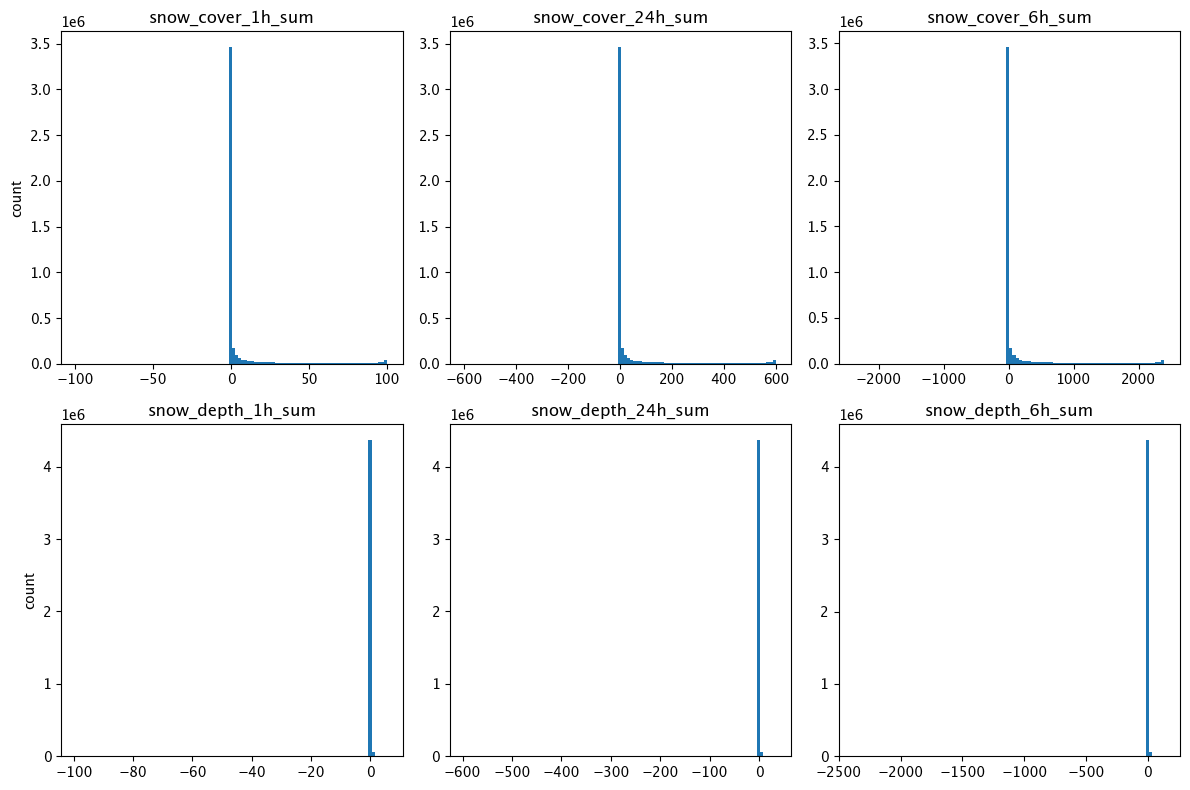

In [24]:
# issues pertaining to snow-related channels
snow_covers=[col for col in dF2.columns if 'snow_cover' in col]
snow_depths=[col for col in dF2.columns if 'snow_depth' in col]

fig,axes=plt.subplots(2,3,figsize=(12,8))

# covers
axes[0,0].hist(dF2['snow_cover_1h_sum'],bins=100)
axes[0,1].hist(dF2['snow_cover_6h_sum'],bins=100)
axes[0,2].hist(dF2['snow_cover_24h_sum'],bins=100)
for col in range(3):axes[0,col].set_title(f'{snow_covers[col]}')
axes[0,0].set_ylabel('count') # count axis label

# depths
axes[1,0].hist(dF2['snow_depth_1h_sum'],bins=100)
axes[1,1].hist(dF2['snow_depth_6h_sum'],bins=100)
axes[1,2].hist(dF2['snow_depth_24h_sum'],bins=100)
for col in range(3):axes[1,col].set_title(f'{snow_depths[col]}')
axes[1,0].set_ylabel('count') # count axis label

snow_flag=(dF2[snow_covers].sum(axis=1)>0)|(dF2[snow_depths].sum(axis=1)>0)

plt.tight_layout()
plt.show()

total rows: 4447835
rows dropped: 43 (0.001%)


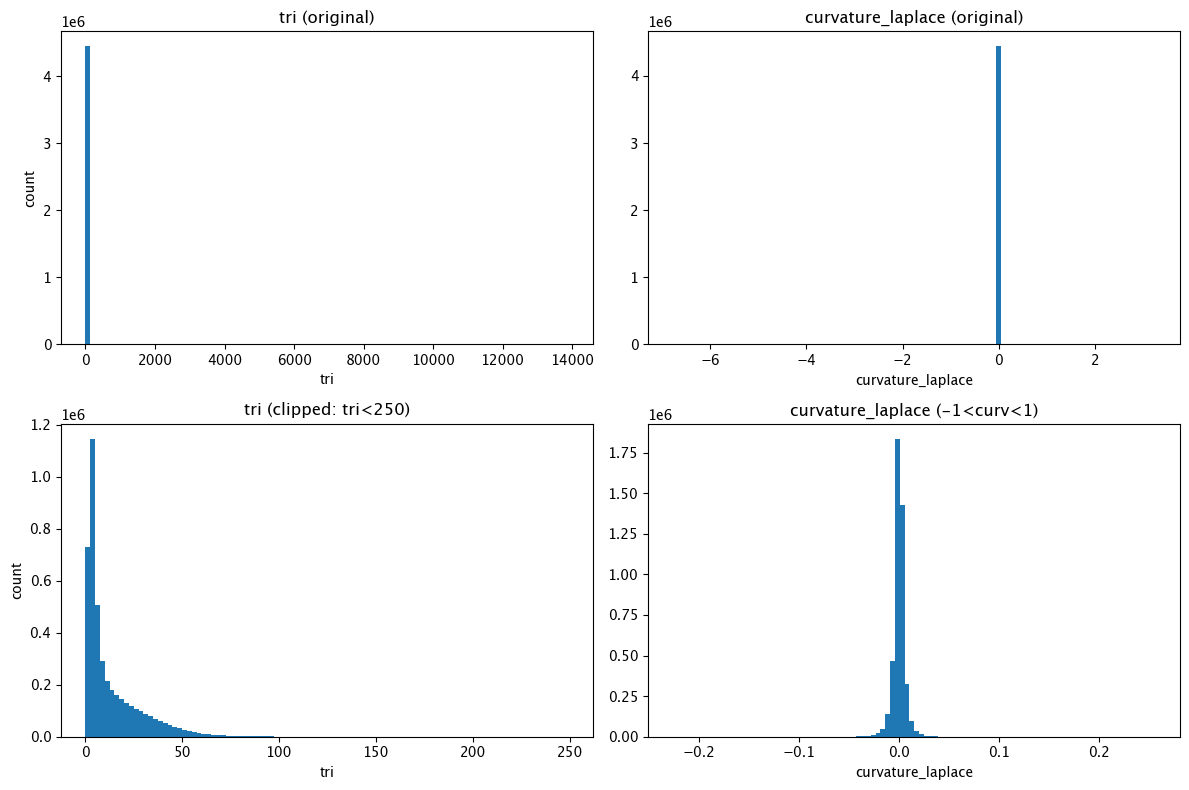

In [25]:
# issues pertaining to tri (terrain ruggedness index) & laplacian curvature
fig,axes=plt.subplots(2,2,figsize=(12,8)) # subplots

# apply masks to tri and curvature such that tri is capped at 250 and curvature is bounded to [-1,1]
mask_tri=dF2['tri']<250
mask_curv=dF2['curvature_laplace'].between(-1,1)
clipped=dF2[mask_tri & mask_curv]

# get number of rows dropped due to constraints, print
dropped=dF2.__len__()-(mask_tri & mask_curv).sum()
print(f'total rows: {dF2.__len__()}')
print(f'rows dropped: {dropped} ({dropped/dF2.__len__():.3%})')

# top row (full & unclipped)
axes[0,0].hist(dF2['tri'],bins=100) # tri 
axes[0,0].set_title('tri (original)')
axes[0,0].set_xlabel('tri')

axes[0,1].hist(dF2['curvature_laplace'],bins=100) # curvature
axes[0,1].set_title('curvature_laplace (original)')
axes[0,1].set_xlabel('curvature_laplace')
axes[0,0].set_ylabel('count') # count axis label

# bottom row (clipped)
axes[1,0].hist(clipped['tri'],bins=100) # tri
axes[1,0].set_title('tri (clipped: tri<250)')
axes[1,0].set_xlabel('tri')

axes[1,1].hist(clipped['curvature_laplace'],bins=100) # curvature
axes[1,1].set_title('curvature_laplace (-1<curv<1)')
axes[1,1].set_xlabel('curvature_laplace')
axes[1,0].set_ylabel('count') # count axis label

# on the graph you can see just how extreme some of the skew/outliers were before clipping
# extremities in other rows are all simply extreme meteorological/topographical conditions whereas these can be attributed to poor calculations (since these are both channels i derived myself)
plt.tight_layout()
plt.show()

### Removal

In [26]:
# calculate ratio of positives to negatives in pre-clean dataset
pos0=dF2[dF2['key']==1].__len__()
neg0=dF2[dF2['key']==0].__len__()
print(f'before {'-'*23}',f'no. positives: {pos0}',f'no. negatives: {neg0}',f'positive %: {pos0/neg0:.2%}\n',sep='\n')

dF2C=dF2[mask_tri & mask_curv] # apply earlier tri & curvature masks
dF2C=dF2C[~(dF2C.drop(meta,axis=1)==config_sampling.get('unmask_val',-99)).any(axis=1)] # now also dropping all rows with ANY null values (surprisingly not very many)
dF2C=dF2C.drop(columns=snow_covers+snow_depths) # drop original snow channels
dF2C['snow_flag']=snow_flag.astype(int) # add snow flag column
dF2C.reset_index(drop=True,inplace=True) # reset index

# calculate ratio of positives to negatives in post-clean dataset
pos1=dF2C[dF2C['key']==1].__len__()
neg1=dF2C[dF2C['key']==0].__len__()
print(f'after --(dropped {pos0+neg0-pos1-neg0} rows)--',f'no. positives: {pos1}',f'no. negatives: {neg1}',f'positive %: {pos1/neg1:.2%}\n',sep='\n')

dF2C # dF2(Cleaned)

before -----------------------
no. positives: 1158984
no. negatives: 3288851
positive %: 35.24%

after --(dropped 85665 rows)--
no. positives: 1073319
no. negatives: 3266452
positive %: 32.86%



,key,weight,region_id,fold_id,aspect_cos,aspect_sin,clay_content_b0,clay_content_b10,clay_content_b100,clay_content_b200,...,surface_runoff_24h_sum,surface_runoff_6h_sum,surface_runoff_72h_sum,tri,twi,vwc_kPa0033_0_5cm,vwc_kPa0033_100_200cm,vwc_kPa1500_0_5cm,vwc_kPa1500_100_200cm,snow_flag
0,1,0.009174,823ce7fffffffff,813cfffffffffff,0.855549,-0.517722,30,30,33,32,...,0.221369,0.080874,0.257301,14.456832,8.579281,0.319410,0.345457,0.167772,0.207706,0
1,1,0.009174,823ce7fffffffff,813cfffffffffff,-0.983325,-0.181856,29,30,32,32,...,0.226790,0.083127,0.263411,4.358899,12.784831,0.320357,0.345601,0.176167,0.207812,0
2,1,0.009174,823ce7fffffffff,813cfffffffffff,1.000000,0.000000,31,32,38,36,...,0.195697,0.008843,0.259904,7.681146,10.754542,0.324196,0.346194,0.169076,0.210739,0
3,1,0.009174,823ce7fffffffff,813cfffffffffff,-0.111959,-0.993713,29,31,33,32,...,0.177656,0.020931,0.284783,10.000000,7.568312,0.317508,0.344574,0.165000,0.197935,0
4,1,0.009174,823ce7fffffffff,813cfffffffffff,0.863572,0.504226,27,27,29,28,...,0.145961,0.026998,0.308366,28.757608,8.257505,0.323334,0.345852,0.181026,0.203187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339766,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.384836,-0.922985,17,18,17,18,...,0.001412,0.000003,0.009575,3.464102,19.834738,0.349198,0.309014,0.159036,0.143900,1
4339767,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.267315,0.963609,17,18,18,17,...,0.002914,0.000422,0.010084,3.000000,11.844219,0.356411,0.320207,0.159707,0.149294,1
4339768,0,97283.339273,8240c7fffffffff,8140fffffffffff,0.857344,-0.514744,18,18,17,17,...,0.001246,0.000011,0.009010,6.928203,8.456839,0.357984,0.323912,0.164670,0.151435,1
4339769,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.639888,0.768468,17,18,18,17,...,0.001421,0.000003,0.009277,2.449490,10.659784,0.355574,0.309309,0.155952,0.158351,1


### Normalization

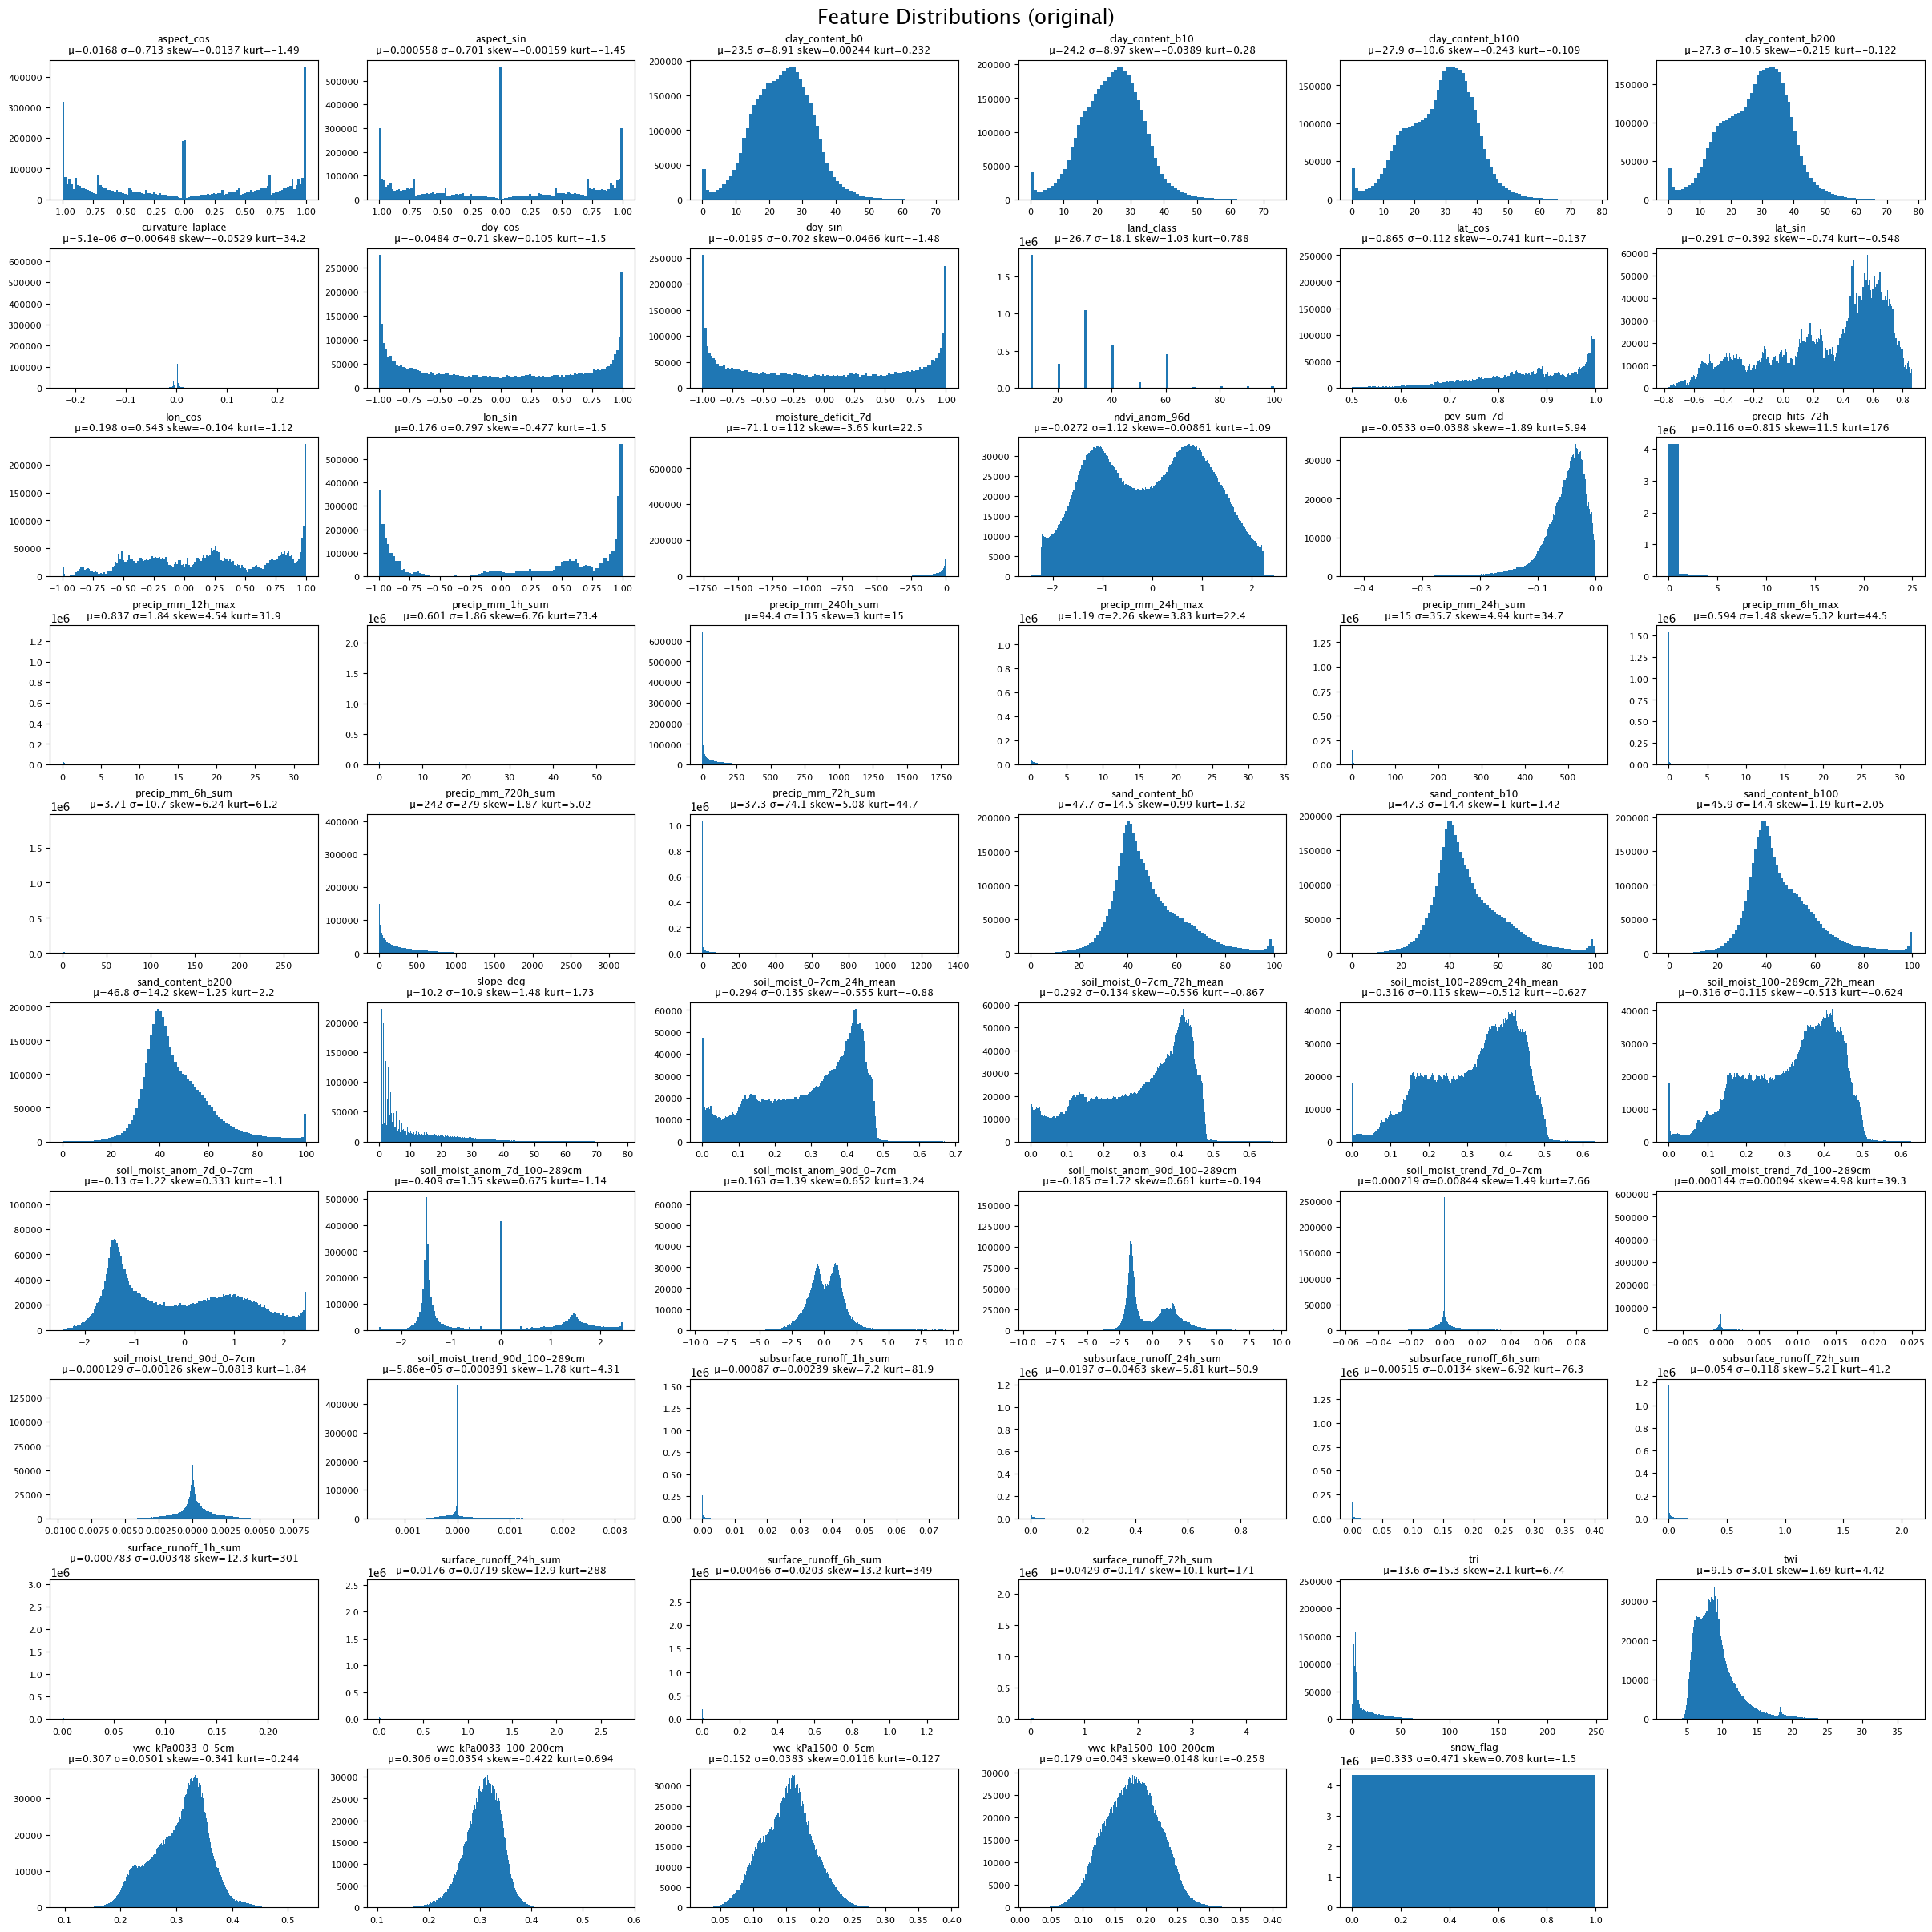

In [27]:
# multiple plotting utility for quick viz
def multiplots(dF,note=None,bins='auto',nrows=10,ncols=6):
    # getting only numeric & non-meta columns
    cols=[c for c in [col for col in dF.columns if col not in meta] if c in dF.select_dtypes(include=[np.number]).columns.tolist()]

    # setting up grid
    fig,axes=plt.subplots(nrows,ncols,figsize=(24,24),constrained_layout=True)
    axes=axes.ravel()

    # loop through all columns and plot
    for idx,col in enumerate(cols):
        ax=axes[idx]
        feature=dF[col]
        # histogram & compute stats
        ax.hist(feature.values,bins=bins,edgecolor='none')
        ax.set_title(f'{col}\nμ={feature.mean():.3g} σ={feature.std(ddof=1):.3g} skew={feature.skew():.3g} kurt={feature.kurt():.3g}',fontsize=9)
        ax.tick_params(axis='both',which='both',labelsize=8)

    # hide unused axes, display overall title
    for plot in range(len(cols),len(axes)):axes[plot].axis('off')
    fig.suptitle(f'Feature Distributions{f' ({note})' if note!=None else ''}',fontsize=18)
    plt.show()

multiplots(dF2C,'original') # plot original distributions

In [28]:
%%skip # already done @ database/outputs/main.csv
# normalize, scale, transform features etc before modeling
# excluding precip_hits_72h from processing (because it's a very sparse integer-based column that likes to be left alone)
dF2M=ftk.transform_full(dF2C,meta,{'precip_hits_72h'},config_path.get('spec'))[0] # dF2(Main)
# save transformed dataset to main.csv
dF2M.to_csv(config_path.get('main'),index=False)

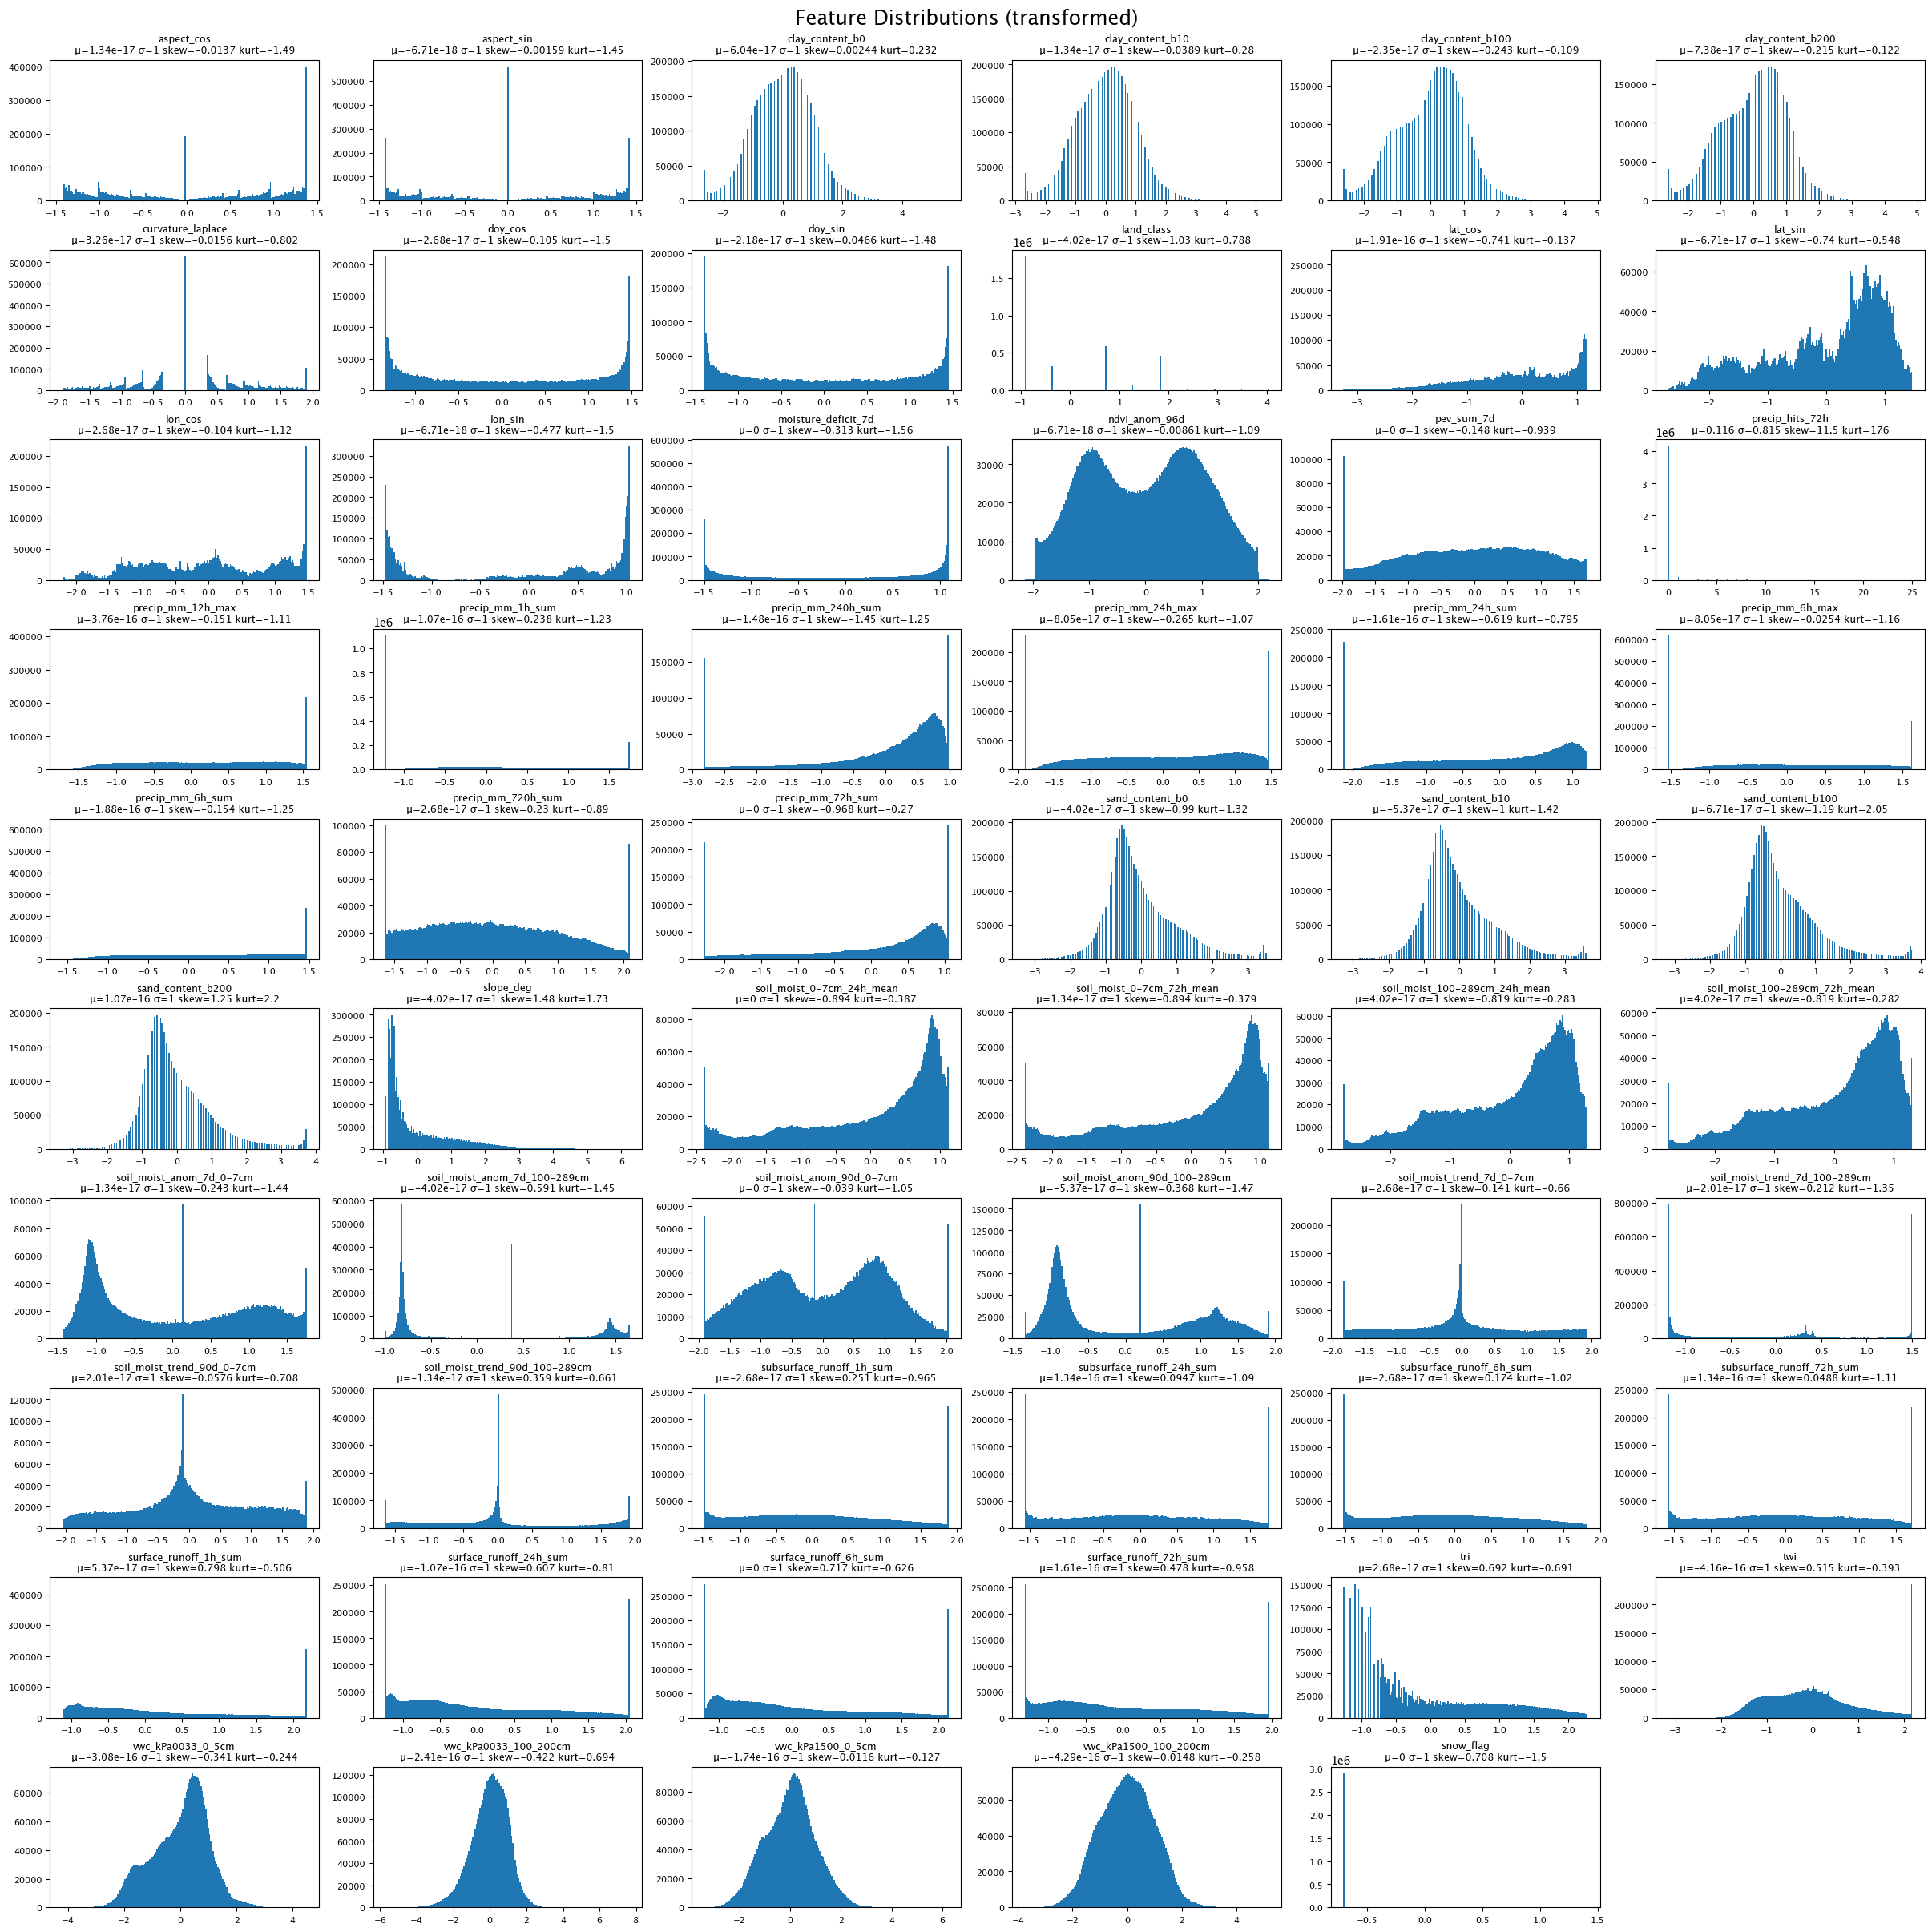

In [29]:
dF2M=pd.read_csv(config_path.get('main')) # full, transformed dataset (finally)
multiplots(dF2M,'transformed',200) # plot transformed distributions

In [30]:
dF2M # the final set of all points, populated with cleaned & transformed features

,key,weight,region_id,fold_id,aspect_cos,aspect_sin,clay_content_b0,clay_content_b10,clay_content_b100,clay_content_b200,...,surface_runoff_24h_sum,surface_runoff_6h_sum,surface_runoff_72h_sum,tri,twi,vwc_kPa0033_0_5cm,vwc_kPa0033_100_200cm,vwc_kPa1500_0_5cm,vwc_kPa1500_100_200cm,snow_flag
0,1,0.009174,823ce7fffffffff,813cfffffffffff,1.176781,-0.739081,0.727348,0.648285,0.478016,0.447955,...,2.055129,2.138805,1.967114,0.413202,-0.115218,0.257414,1.110668,0.399104,0.677761,-0.706969
1,1,0.009174,823ce7fffffffff,813cfffffffffff,-1.403311,-0.260128,0.615053,0.648285,0.384057,0.447955,...,2.055129,2.138805,1.967114,-0.630247,1.498498,0.276323,1.114749,0.618455,0.680209,-0.706969
2,1,0.009174,823ce7fffffffff,813cfffffffffff,1.379457,-0.000796,0.839644,0.871263,0.947809,0.830462,...,2.055129,1.596113,1.967114,-0.194193,0.751367,0.352978,1.131465,0.433176,0.748231,-0.706969
3,1,0.009174,823ce7fffffffff,813cfffffffffff,-0.180713,-1.417856,0.615053,0.759774,0.478016,0.447955,...,2.055129,2.124177,1.967114,0.042107,-0.546235,0.219442,1.085758,0.326697,0.450702,-0.706969
4,1,0.009174,823ce7fffffffff,813cfffffffffff,1.188038,0.718243,0.390461,0.313818,0.102181,0.065449,...,2.055129,2.138805,1.967114,1.256081,-0.250256,0.335765,1.121812,0.745396,0.572739,-0.706969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339766,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.563581,-1.316996,-0.732497,-0.689583,-1.025323,-0.890817,...,0.174256,-0.662279,0.409294,-0.782715,2.180120,0.852142,0.082639,0.170879,-0.804850,1.414489
4339767,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.398690,1.373335,-0.732497,-0.689583,-0.931364,-0.986444,...,0.412759,0.307950,0.429089,-0.871796,1.158951,0.996161,0.398367,0.188410,-0.679498,1.414489
4339768,0,97283.339273,8240c7fffffffff,8140fffffffffff,1.179299,-0.734834,-0.620201,-0.689583,-1.025323,-0.986444,...,0.136545,-0.493155,0.386338,-0.280527,-0.166375,1.027560,0.502904,0.318067,-0.629755,1.414489
4339769,0,97283.339273,8240c7fffffffff,8140fffffffffff,-0.921440,1.095059,-0.732497,-0.689583,-0.931364,-0.986444,...,0.176183,-0.645229,0.397336,-0.989593,0.715149,0.979448,0.090964,0.090291,-0.469059,1.414489


In [31]:
# thanks for your time